In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

/Users/arokem/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import sklearn.cross_validation as xval

In [3]:
names = ["mpg","cyl","disp","hp","weight","accel","year","origin","name"]

In [4]:
df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data", names=names, sep="\s+")

In [5]:
df["hp"] = pd.to_numeric(df["hp"], errors="coerce")
df = df.dropna()

In [6]:
df.shape

(392, 9)

In [7]:
y = df["mpg"].as_matrix()
X = df.drop(["mpg", "name"], axis=1).as_matrix()


In [8]:
X.shape

(392, 7)

In [9]:
X

array([[   8. ,  307. ,  130. , ...,   12. ,   70. ,    1. ],
       [   8. ,  350. ,  165. , ...,   11.5,   70. ,    1. ],
       [   8. ,  318. ,  150. , ...,   11. ,   70. ,    1. ],
       ..., 
       [   4. ,  135. ,   84. , ...,   11.6,   82. ,    1. ],
       [   4. ,  120. ,   79. , ...,   18.6,   82. ,    1. ],
       [   4. ,  119. ,   82. , ...,   19.4,   82. ,    1. ]])

(array([  27.,   95.,  120.,   44.,   19.,   47.,   13.,   14.,    5.,    8.]),
 array([  46. ,   64.4,   82.8,  101.2,  119.6,  138. ,  156.4,  174.8,
         193.2,  211.6,  230. ]),
 <a list of 10 Patch objects>)

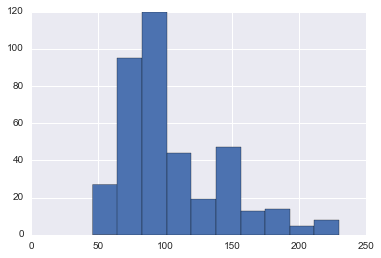

In [10]:
plt.hist(X[:, 2])

In [11]:
X_train, X_test, y_train, y_test = xval.train_test_split(X, y, test_size=0.33, random_state=42)

In [12]:
clf = RandomForestRegressor(oob_score=True)

In [13]:
clf.fit(X_train, y_train)

/Users/arokem/anaconda/lib/python3.5/site-packages/sklearn/ensemble/forest.py:687: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=True, random_state=None,
           verbose=0, warm_start=False)

In [14]:
y_hat = clf.predict(X_test)

In [15]:
n_trees = clf.n_estimators
est0 = clf.estimators_[0]

In [16]:
est0.tree_.weighted_n_node_samples

array([ 262.,  143.,   52.,   28.,   25.,    3.,    2.,    1.,   22.,
          4.,    2.,    2.,    1.,    1.,   18.,   13.,   11.,    7.,
          2.,    1.,    1.,    5.,    3.,    1.,    2.,    2.,    4.,
          2.,    2.,    2.,    5.,    4.,    2.,    2.,    1.,    3.,
          1.,    2.,   24.,   17.,   10.,    6.,    1.,    5.,    1.,
          4.,    4.,    1.,    3.,    1.,    2.,    7.,    3.,    2.,
          1.,    4.,    3.,    2.,    1.,    1.,    7.,    5.,    1.,
          4.,    1.,    3.,    2.,   91.,   47.,   16.,   14.,   12.,
          1.,   11.,    5.,    1.,    4.,    6.,    2.,    4.,    2.,
          2.,    2.,    2.,    1.,    1.,   31.,   27.,   11.,    5.,
          2.,    3.,    6.,    4.,    1.,    3.,    2.,    1.,    1.,
         16.,   11.,    9.,    7.,    1.,    6.,    3.,    3.,    2.,
          2.,    5.,    2.,    1.,    1.,    3.,    1.,    2.,    4.,
          3.,    2.,    1.,    1.,   44.,    6.,    4.,    1.,    3.,
          1.,    2.,

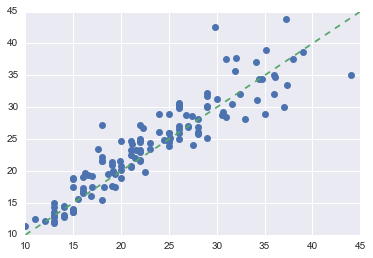

In [17]:
plt.plot(y_test, y_hat, 'o')
plt.plot([10, 45], [10, 45], '--')